In [1]:
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import skimage.io

from collections import defaultdict
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import re
import tifffile as tiff
import pickle

import networkx as nx
from sklearn.model_selection import train_test_split

import torch_geometric.utils
import torch

C:\Users\eozturk7\AppData\Local\miniconda3\envs\torch_gpu2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
#p_dir = (Path().cwd().parents[0]).absolute()
p_dir = 'Y:\\coskun-lab\\Efe and Nishkala\\SnowflakePipeline'

module_path = str(p_dir + "\\src")

if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
#data_dir = (Path().cwd().parents[0] / 'data').absolute()
data_dir = (p_dir + '\\Data')

In [6]:
import graph
import torch
import torch_geometric.utils
import networkx as nx
import lightning.pytorch as pl
import torch.utils.data as data

#spatial_omics_folder = (Path().cwd().parents[0]).absolute() / 'data' / 'spatial_omics_graph_external'
spatial_omics_folder = p_dir + '\\Data' + '\\spatial_omics_graph_external'
#process_path = (Path().cwd().parents[0]).absolute() / 'data' / 'torch_graph_data'
process_path = p_dir + '\\Data' + '\\torch_graph_data'

In [46]:
def visualize_graph(G, pos, color, save_dir, save_name, **kwargs):
    fig, ax = plt.subplots(figsize=(15,15))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=pos, with_labels=False, 
                     node_color=color, ax=ax, **kwargs)
    ax.axis('equal')
    ax.invert_yaxis()
    ax.set_facecolor('k')
    plt.savefig(f'{save_dir}\\{save_name}.jpg', dpi=1200, bbox_inches='tight', pad_inches=0)
    plt.show()

## Read data Frame

In [31]:
import scanpy as sc
import anndata as ad 
# Import spatial omics library
import athena as ath
from spatialOmics import SpatialOmics

import networkx as nx
import matplotlib 

# Adata path 
# path = r'Y:\coskun-lab\Thomas\graph\Covid IMC 2\results\covid-imc.h5ad'
save_path = (Path().cwd().parents[0]).absolute() / 'data' / 'adata'

# adata_combined = ad.read_h5ad(save_path / 'all.h5ad')
adata = ad.read_h5ad(save_path / 'breast.h5ad')

sc.pl.heatmap(adata, adata.var_names, groupby='metacluster_label')

# Extract node class and colors
var = 'metacluster_label'

# cluster_label_order = adata.uns[f'dendrogram_{var}']['categories_ordered']

colors = adata.uns[f"{var}_colors"]
labels = adata.obs[var].cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}

df_cell_info = adata.obs.copy()


c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


ValueError: groupby has to be a valid observation. Given metacluster_label, is not in observations: ['metabricId', 'core_id', 'ImageNumber', 'ObjectNumber', 'Location_Center_X', 'Location_Center_Y', 'SOM_nodes', 'pg_cluster', 'description']

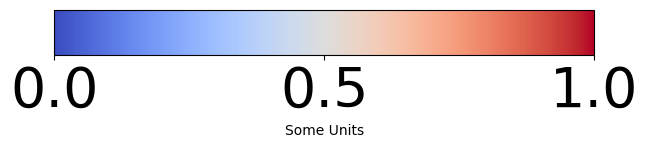

In [32]:

import matplotlib.pyplot as plt
import matplotlib as mpl

# Make a figure and axes with dimensions as desired.
fig = plt.figure(figsize=(6, 3))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])

# Set the colormap and norm to correspond to the data for which
# the colorbar will be used.
cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=0, vmax=1)

# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar.  There are many more kwargs, but the
# following gives a basic continuous colorbar with ticks
# and labels.
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.ax.tick_params(labelsize=40)
cb1.set_label('Some Units')

# Get Dataset

In [15]:
import graph
import torch

from torch_geometric.loader import DataLoader
seed = torch.Generator().manual_seed(42)

name = 'TLS_efe6'

# Crate dataset
dataset = graph.GraphDataset(process_path + '\\' + name, process_path + '\\' + name + '\\' + 'info.csv', 4, y_name='y')

train_set, val_set, test_set = graph.train_test_val_split(dataset)

# Create Dataloader
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)



In [16]:
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.nc}')

Dataset: GraphDataset(34):
Number of graphs: 34
Number of features: 58
Number of classes: 4


In [17]:
print(f'Train set: {len(train_set)}, val set: {len(test_set)}, val set: {len(val_set)}')

Train set: 17, val set: 13, val set: 4


# Load model

Get the best model from all

In [32]:
### Load GNN 
from graph.model2 import NodeLevelGNN, GraphLevelGNN, GraphLevelGNN_Moprh, GraphLevelGNN_Pos
from pytorch_lightning.utilities.model_summary import ModelSummary

# Model path
condition = 'SF_15082024_tls_snowflake_pos_3'
checkpoint_folder = (Path().cwd().parents[0]).absolute() / 'data' / "saved_models" / f"Graph_GNNs_{condition}" 
project_name = f'SF_{condition}'

# Model parameters
NUM_LAYERS = 3
HIDDEN_CHANNELS = 32
pool = 'attention'
model ='GinConv'
fold = 1
pl.seed_everything(42)

# Load model
CHECKPOINT_PATH = checkpoint_folder / f'{model}_{NUM_LAYERS}_{HIDDEN_CHANNELS}_{fold}' / pool
checkpoint = CHECKPOINT_PATH / f"GraphLevel{model}" / f"GraphLevel{model}.ckpt" 
graph_model = GraphLevelGNN_Pos.load_from_checkpoint(checkpoint, map_location=torch.device('cpu'))
graph_model.eval()

# Print model
summary = ModelSummary(graph_model)
print(summary)

Seed set to 42


   | Name        | Type             | Params | Mode
---------------------------------------------------------
0  | model       | GIN              | 7.5 K  | eval
1  | fnn_layer   | Linear           | 1.1 K  | eval
2  | selu        | SELU             | 0      | eval
3  | head        | Linear           | 66     | eval
4  | loss_module | CrossEntropyLoss | 0      | eval
5  | train_acc   | BinaryAccuracy   | 0      | eval
6  | train_auroc | BinaryAUROC      | 0      | eval
7  | train_f1    | BinaryF1Score    | 0      | eval
8  | valid_acc   | BinaryAccuracy   | 0      | eval
9  | valid_auroc | BinaryAUROC      | 0      | eval
10 | valid_f1    | BinaryF1Score    | 0      | eval
11 | test_acc    | BinaryAccuracy   | 0      | eval
12 | test_auroc  | BinaryAUROC      | 0      | eval
13 | test_f1     | BinaryF1Score    | 0      | eval
14 | pool        | GlobalAttention  | 33     | eval
---------------------------------------------------------
8.6 K     Trainable params
0         Non-trainable p

C:\Users\eozturk7\AppData\Local\miniconda3\envs\torch_gpu2\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


# Graph explainer

In [33]:
from torch_geometric.explain import Explainer, PGExplainer, GNNExplainer, CaptumExplainer, AttentionExplainer
from torch_geometric.utils import remove_self_loops, to_undirected
import random
from collections import defaultdict

def aggregate_edge_directions(edge_mask, edge_index):
    edge_mask_dict = defaultdict(float)
    for val, u, v in list(zip(edge_mask, *edge_index)):
        u, v = u.item(), v.item()
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict
    

In [124]:
data = dataset[15]
# data = dataset[4]
# data = dataset[287]
print(data.x.shape[0], data.y, data.name)
data = data.to(graph_model.device)
pos = np.array(data.pos)
img_name = data.name.split('\\')[-1][:-3]

748 tensor([1]) Y:\coskun-lab\Efe and Nishkala\SnowflakePipeline\Data\torch_graph_data\TLS_efe6\reg038.pt


### GNN Explainer Edge Level Importance

In [125]:
explainer = Explainer(
    model=graph_model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type="model",
    node_mask_type=None,
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='graph',
        return_type='probs',
    ),
    # Include only the top 10 most important edges:
    # threshold_config=dict(threshold_type='topk', value=20),
)

edge_index, edge_attr = remove_self_loops(data.edge_index, data.edge_attr)
explanation = explainer(data.x, edge_index, target=data.y, edge_attr=edge_attr, data=data)

C:\Users\eozturk7\AppData\Local\miniconda3\envs\torch_gpu2\Lib\site-packages\torch_geometric\explain\explainer.py:193: UserWarning: The 'target' should not be provided for the explanation type 'model'
  warnings.warn(


In [126]:
# Get edge_color 
edge_color = explanation.edge_mask.detach().cpu().numpy()
if data.y ==0:
    edge_color = -edge_color
edge_color_dict = aggregate_edge_directions(edge_color, edge_index)

edges = tuple(edge_color_dict.keys())
edge_color = np.array(list(edge_color_dict.values()))
edge_color = (edge_color-np.quantile(edge_color, 0.01))/(np.quantile(edge_color, 0.99)-np.quantile(edge_color, 0.01))
edge_color = np.clip(edge_color, a_min=0, a_max=1)

1010 505 505


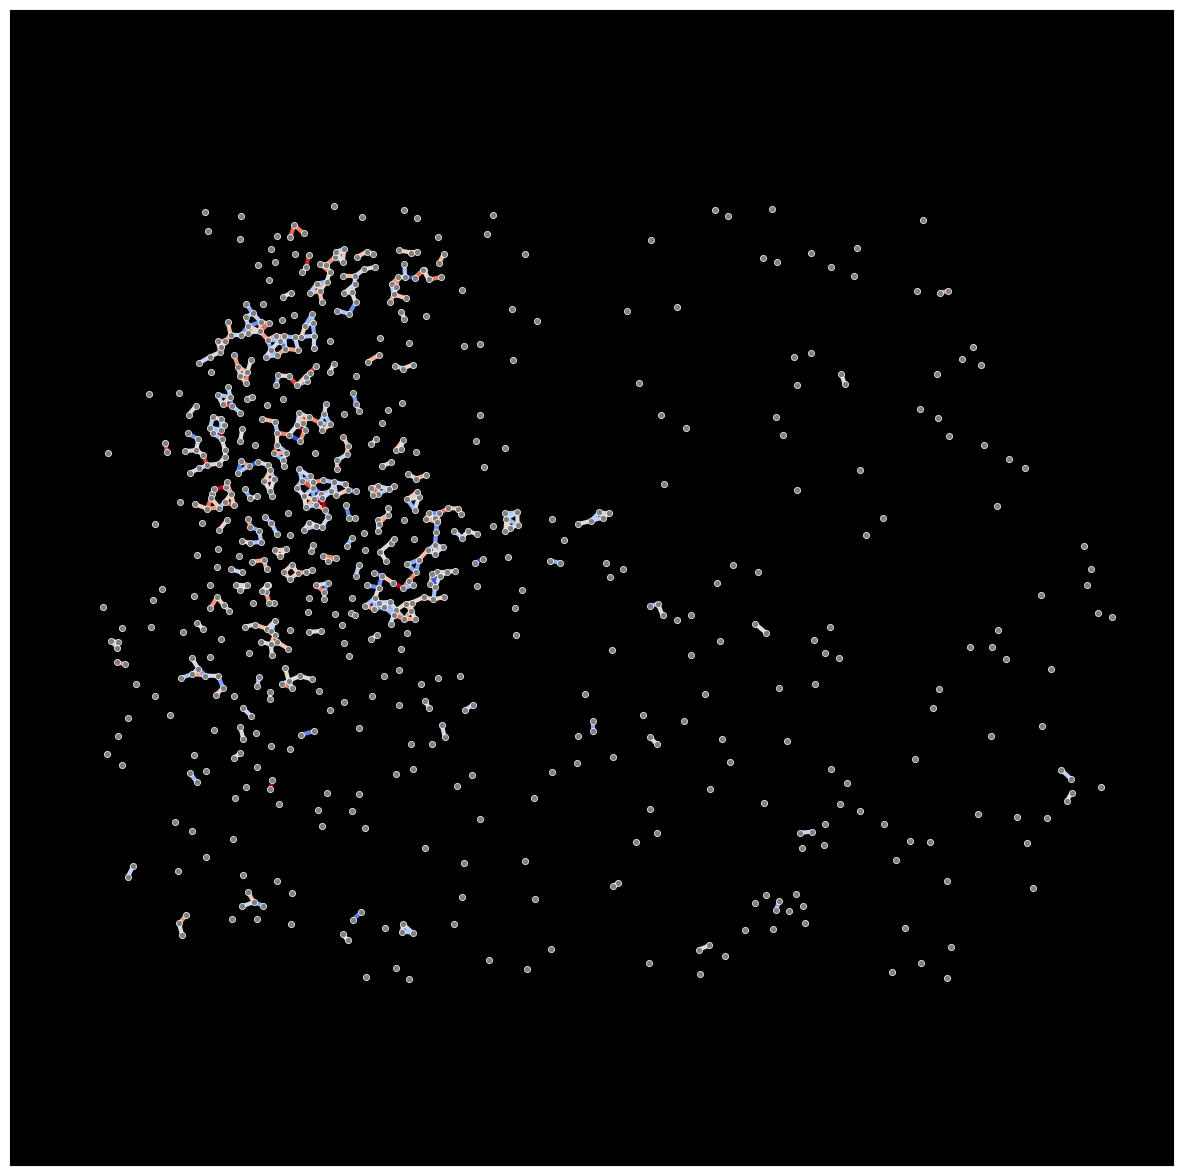

In [127]:
G = torch_geometric.utils.to_networkx(data,remove_self_loops=True, to_undirected=True)
edges = G.edges()
print(len(edge_index[0]), len(edge_color), len(edges))

pos = data.pos.cpu().numpy()
        
visualize_graph(G, pos, 'gray',
    'Y:\\coskun-lab\\Efe and Nishkala\\SnowflakePipeline\\11_snowflakes\\notebooks\\figures',
    f'tls_{img_name}_gnn_explainer_edge_importance',
    edgecolors='w',
    linewidths=0.5,
    node_size=20, 
    edgelist=edges, 
    edge_cmap=plt.cm.coolwarm, 
    edge_color=edge_color, 
    # width=[x * 5 for x in edge_color], 
    width=3,
    arrows=False)

### GNN Explainer Node Level Importance

In [128]:
explainer = Explainer(
    model=graph_model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type="model",
    node_mask_type='object',
    edge_mask_type=None,
    model_config=dict(
        mode='binary_classification',
        task_level='graph',
        return_type='probs',
    ),
    # Include only the top 10 most important edges:
    # threshold_config=dict(threshold_type='topk', value=20),
)

In [129]:
explanation = explainer(data.x, data.edge_index, target=data.y, edge_attr=data.edge_attr, data=data)

C:\Users\eozturk7\AppData\Local\miniconda3\envs\torch_gpu2\Lib\site-packages\torch_geometric\explain\explainer.py:193: UserWarning: The 'target' should not be provided for the explanation type 'model'
  warnings.warn(


In [130]:
# Get edge_color 
node_color = explanation.node_mask.detach().cpu().numpy()
node_color = (node_color-node_color.min())/(node_color.max()-node_color.min())

1010 505 505


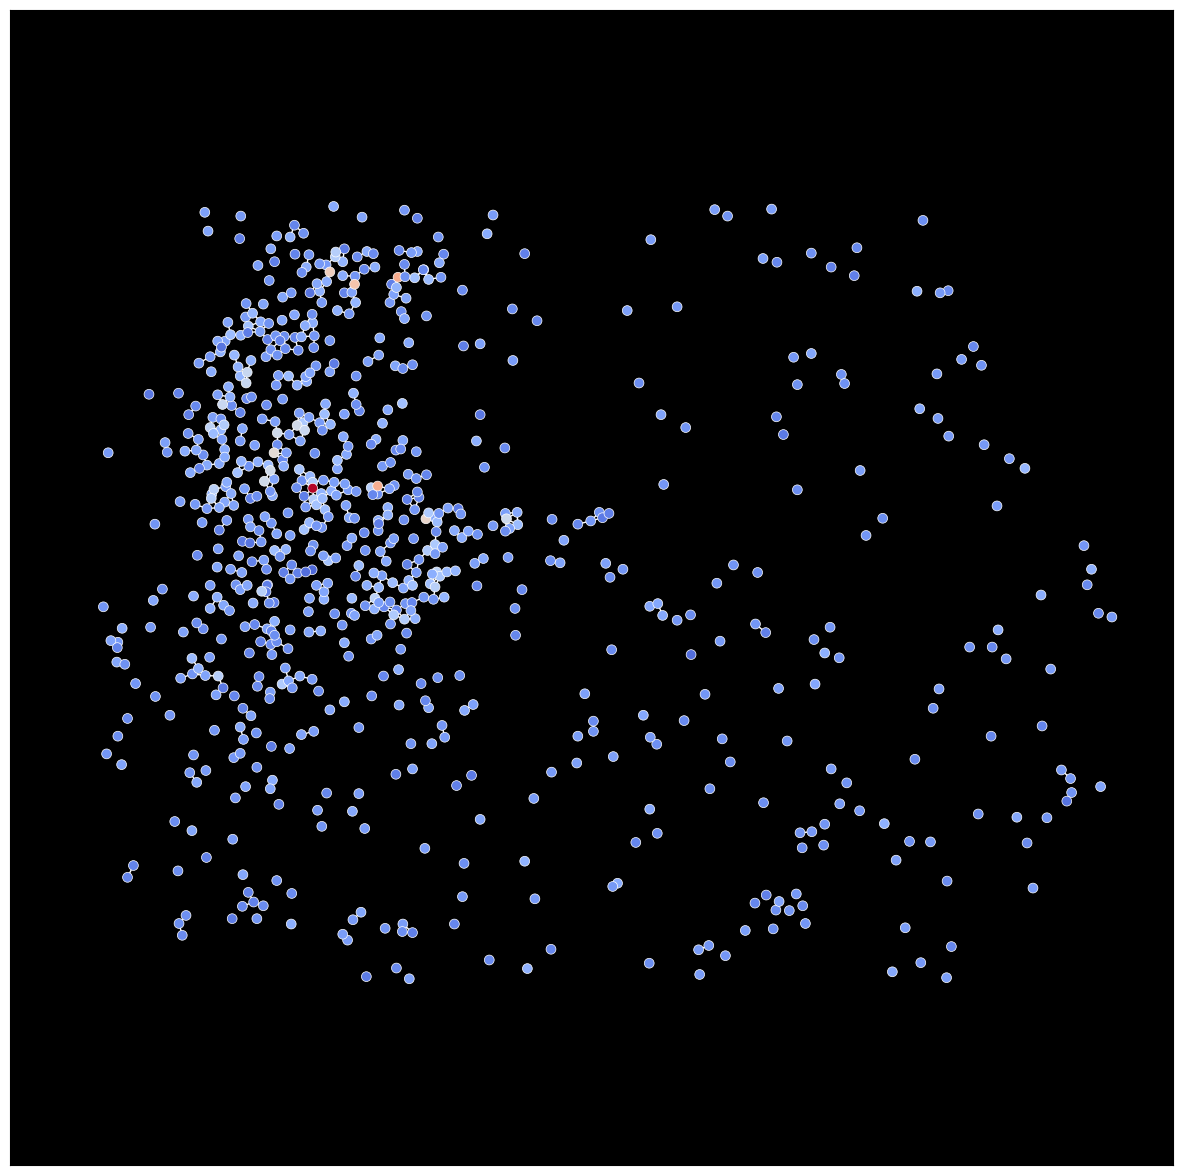

In [131]:
G = torch_geometric.utils.to_networkx(data,remove_self_loops=True, to_undirected=True)
edges = G.edges()
print(len(edge_index[0]), len(edge_color), len(edges))

pos = data.pos
        
visualize_graph(G, pos, node_color,
    'Y:\\coskun-lab\\Efe and Nishkala\\SnowflakePipeline\\11_snowflakes\\notebooks\\figures',
    f'tls_{img_name}_gnn_explainer_node_importance',
    edgecolors='w',
    linewidths=0.5,
    node_size=50, 
    edge_color='w', 
    cmap='coolwarm',
    arrows=False)